PB1
PB2
iteration 1
PB1
PB2
iteration 2
PB1
PB2
iteration 3
PB1
PB2


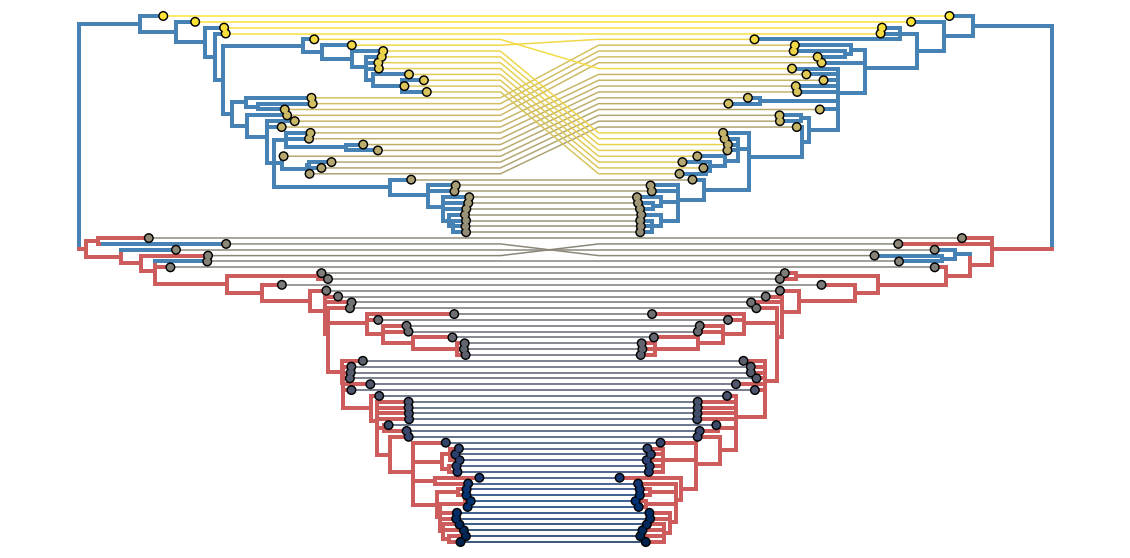

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

import requests
from io import StringIO as sio
import numpy as np
import baltic as bt

segments=['PB1','PB2']

trees={} ## dict
for segment in segments:
    print(segment,)
    address=r'https://raw.githubusercontent.com/evogytis/fluB/master/data/mcc%%20trees/InfB_%st_ALLs1.mcc.tre'%(segment) ## address of example tree
    
    fetch_tree = requests.get(address) ## fetch tree
    treeFile=sio(fetch_tree.text) ## stream from repo copy
    
    ll=bt.loadNexus(treeFile,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file
    trees[segment]=ll.collapseBranches(lambda k:k.traits['posterior']<0.5) ## add tree object to dict
    if segment=='PB1':
        subset_tips=[w.name for i,w in enumerate(ll.getExternal()) if i%5==0]
    trees[segment]=trees[segment].reduceTree([w for w in ll.getExternal() if w.name in subset_tips]) ## reduce tree to every 5th tip, to make plotting faster later
    
    
tip_positions={x:{} for x in segments} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y) ## remember (X, Y) position of tip

cmap=mpl.cm.Spectral

tip_positions={x:{} for x in trees} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y) ## remember (X, Y) position of tip

cmap=mpl.cm.Spectral

for X in range(3): ## 10 untangling iterations
    print('iteration %d'%(X+1))
    for t,tr in enumerate(segments): ## iterate over each tree
        print(tr)
        ptr=segments[t-1] ## previous tree
        ntr=segments[t] ## next tree
        seg=trees[ptr] ## fetch appropriate tree
        nex_seg=trees[ntr]
        for k in sorted(nex_seg.Objects,key=lambda q:q.height): ## iterate over branches from most recent to oldest
            if k.branchType=='node': ## can only sort nodes
                leaves=[w.leaves if w.branchType=='node' else [w.name] for w in k.children] ## descendent tips in current order
                
                for c in range(len(leaves)):
                    leaves[c]=sorted(leaves[c],key=lambda x:tip_positions[ntr][x][1] if x in tip_positions[ntr] else 0.0) ## sort leaves according to their positions in the next tree
                
                ys=[sorted([tip_positions[ntr][w][1] for w in cl if w in tip_positions[ntr]]) for cl in leaves] ## extract y positions of descendents
                merge_ys=sum(ys,[]) ## flatten list of tip y coordinates
                ypos=range(int(min(merge_ys)),int(max(merge_ys))+1) ## get y positions of tips in current order
                order={i:x for i,x in enumerate(leaves)} ## dict of tip order: tip name
                
                new_order=sorted(order.keys(),key=lambda x:-np.mean([(tip_positions[ptr][order[x][w]][1]-ypos[w]) for w in range(min([len(order[x]),len(ypos)])) if order[x][w] in tip_positions[ptr]])) ## get new order by sorting existing order based on y position differences
                
                if new_order!=range(len(leaves)): ## if new order is not current order
                    k.children=[k.children[i] for i in new_order] ## assign new order of child branches
                    nex_seg.drawTree() ## update y positions

                    for w in nex_seg.Objects: ## iterate over objects in next tree
                        if w.branchType=='leaf':
                            tip_positions[ntr][w.name]=(w.height,w.y) ## remember new positions
                
        if t==0: ## if first tree
            trees[segments[t]].drawTree() ## update positions
            lvs=sorted([w for w in trees[segments[t]].Objects if w.branchType=='leaf'],key=lambda x:x.y) ## get leaves in y position order
            
            norm=mpl.colors.Normalize(0,len(lvs))
            pos_colours={w.name:cmap(norm(w.y)) for w in lvs} ## assign colour
            

fig = plt.subplots(figsize=(20,10),facecolor='w')

gs = GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

traitName='HA'
tree1=trees['PB1']
tree2=trees['PB2']

cmap=mpl.cm.cividis
x_attr=lambda k: k.height ## branch x position is determined by height
c_func=lambda k: 'indianred' if k.traits[traitName]=='V' else 'steelblue'
ct_func=lambda k: cmap(k.y/float(tree1.ySpan)) ## call colour map with fraction that represents the y position of a tip (returns colour)

tree1.plotTree(ax,x_attr=x_attr,width=4,colour=c_func) ## plot black tree
tree1.plotPoints(ax,x_attr=x_attr,size=50,colour=ct_func,zorder=100) ## plot circles at tips


skip=tree1.treeHeight*0.35 ## skip this many units between trees
x_attr=lambda k: tree1.treeHeight+skip+tree2.treeHeight-k.height ## for tree2 we'll offset x coordinates by the height of the tree and invert branches
tree2.plotTree(ax,x_attr=x_attr,width=4,colour=c_func) ## plot black tree
tree2.plotPoints(ax,x_attr=x_attr,size=50,colour=ct_func,zorder=100) ## plot circles at tips

for k in filter(lambda x: x.branchType=='leaf',tree1.Objects): ## grab leaf objects in tree1
    x=k.height ## get height
    y=k.y ## get y position
    
    matching_tip=tree2.getBranches(lambda x: x.branchType=='leaf' and x.name==k.name) ## fetch corresponding branch in tree2
    match_y=matching_tip.y
    xs=[x,tree1.treeHeight+0.15*skip,tree1.treeHeight+skip-0.15*skip,x_attr(matching_tip)] ## x coordinates for tangleline
    ys=[y,y,match_y,match_y] ## y coordinates for tangleline
    ax.plot(xs,ys,color=cmap(y/float(tree1.ySpan))) ## plot tangleline
    
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(-1,tree1.ySpan+1) ## set y limits
ax.set_xlim(-5,tree1.treeHeight+skip+tree2.treeHeight+5)

plt.show()